# Hespress Topic Classification

In [46]:
import pandas as pd
import numpy as np
import re
from pathlib import Path
from matplotlib import pyplot as plt

DATAPATH = Path("Data")
STORIES_FILES = [
    'stories_art-et-culture.csv',
    'stories_economie.csv',
    'stories_faits-divers.csv',
    'stories_marocains-du-monde.csv',
    'stories_medias.csv',
    'stories_orbites.csv',
    'stories_politique.csv',
    'stories_regions.csv',
    'stories_societe.csv',
    'stories_sport.csv',
    'stories_tamazight.csv'
]

## Read Data

In [47]:
dfs = []
for file in STORIES_FILES:
        df = pd.read_csv(DATAPATH / file, index_col=0)
        dfs.append(df)
stories_df = pd.concat(dfs, ignore_index=True)

## Data Processing

In [48]:
def arabic_date_parser(date):
    morocian_months_mapper = {
        'يناير': 'January',
        'فبراير': 'February',
        'مارس': 'March',
        'أبريل': 'April',
        'ماي': 'May',
        'يونيو': 'June',
        'يوليوز': 'July',
        'غشت': 'August',
        'شتنبر': 'September',
        'أكتوبر': 'October',
        'نونبر': 'November',
        'دجنبر': 'December'
    }

    date_pattern = r'(السبت|الأحد|الاثنين|الثلاثاء|الأربعاء|الخميس|الجمعة)\s(?P<day>\d{2})\s+(?P<month>يناير|فبراير|مارس|أبريل|ماي|يونيو|يوليوز|غشت|شتنبر|أكتوبر|نونبر|دجنبر)\s+(?P<year>\d{4})\s+-\s+(?P<time>\d{2}:\d{2})'

    match = re.match(date_pattern, date)
    day = match.group('day')

    month = match.group('month')
    month = morocian_months_mapper[month]
    year = match.group('year')
    time = match.group('time')
    parsed_date = day + ' ' + month + ' ' + year + ' - ' + time
    return parsed_date

In [49]:
stories_df["date"] = pd.to_datetime(stories_df["date"].apply(arabic_date_parser))
stories_df["day"] = stories_df["date"].dt.day.astype("category")
stories_df["month"] = stories_df["date"].dt.month.astype("category")
stories_df["year"] = stories_df["date"].dt.year.astype("category")

stories_df["author"] = stories_df["author"].astype("category")

## Data Split

Train and test split will be done such as test data should be the last 20% story from each topic, from the [EDA Notebook](https://github.com/moziada/WideBot-T2-Hespress-EDA) we know that each different topic has 1000 story and the data contains 11 different topics.

In [50]:
train_idx = []
for i in range(11):
    start_idx = i * 1000
    end_idx = start_idx + 800
    train_idx.append(np.arange(start_idx, end_idx, 1))
train_idx = np.concatenate(train_idx)

test_idx = []
for i in range(11):
    start_idx = i * 1000 + 800
    end_idx = start_idx + 200
    test_idx.append(np.arange(start_idx, end_idx, 1))
test_idx = np.concatenate(test_idx)

In [51]:
X_cols = ["author", "story", "day", "month", "year"]
y_col = "topic"

X_train = stories_df.loc[train_idx, X_cols]
y_train = stories_df.loc[train_idx, y_col]

X_test = stories_df.loc[test_idx, X_cols]
y_test = stories_df.loc[test_idx, y_col]

## Modeling

In [52]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder

vectorizer = CountVectorizer(ngram_range=(2, 2), max_features=10000, token_pattern=r'[ء-ي]+').fit(X_train["story"])
target_encoder = LabelEncoder().fit(y_train)

In [53]:
train_stories_vectorized = pd.DataFrame(vectorizer.transform(X_train["story"]).toarray(), index=train_idx)
X_train = pd.concat([X_train, train_stories_vectorized], axis=1).drop("story", axis=1)

test_stories_vectorized = pd.DataFrame(vectorizer.transform(X_test["story"]).toarray(), index=test_idx)
X_test = pd.concat([X_test, test_stories_vectorized], axis=1).drop("story", axis=1)

y_train = target_encoder.transform(y_train)
y_test = target_encoder.transform(y_test)

In [54]:
import lightgbm as lgb

cat_features = ["day", "month", "year", "author"]
dtrain = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
dtest = lgb.Dataset(X_test, label=y_test, categorical_feature=cat_features)

In [55]:
model_params = {
    "metrics": ['multi_logloss'],
    "verbosity": -1,
    "seed": 10,
    'objective': 'multiclass',
    'num_class': 11,
    #'max_depth': 4,
    #'min_split_gain': 0.2,
    #'num_leaves': 10,
    #'learning_rate': 0.2,
}

eval_callbacks = [lgb.early_stopping(50, verbose=1)]

clf = lgb.train(model_params,
                dtrain,
                num_boost_round=1500,
                categorical_feature=cat_features,
                valid_sets=[dtest],
                callbacks=eval_callbacks)

c:\Users\mohamed\anaconda3\envs\ml\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\mohamed\anaconda3\envs\ml\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's multi_logloss: 2.00822
Training until validation scores don't improve for 50 rounds
[2]	valid_0's multi_logloss: 1.82481
[3]	valid_0's multi_logloss: 1.7143
[4]	valid_0's multi_logloss: 1.61712
[5]	valid_0's multi_logloss: 1.55085
[6]	valid_0's multi_logloss: 1.50288
[7]	valid_0's multi_logloss: 1.46954
[8]	valid_0's multi_logloss: 1.43469
[9]	valid_0's multi_logloss: 1.4091
[10]	valid_0's multi_logloss: 1.3927
[11]	valid_0's multi_logloss: 1.38288
[12]	valid_0's multi_logloss: 1.37718
[13]	valid_0's multi_logloss: 1.37447
[14]	valid_0's multi_logloss: 1.37182
[15]	valid_0's multi_logloss: 1.36312
[16]	valid_0's multi_logloss: 1.3625
[17]	valid_0's multi_logloss: 1.36401
[18]	valid_0's multi_logloss: 1.35711
[19]	valid_0's multi_logloss: 1.35288
[20]	valid_0's multi_logloss: 1.35406
[21]	valid_0's multi_logloss: 1.3458
[22]	valid_0's multi_logloss: 1.34752
[23]	valid_0's multi_logloss: 1.34343
[24]	valid_0's multi_logloss: 1.33887
[25]	valid_0's multi_logloss: 1.33902
[26

In [56]:
y_pred = []
for y in clf.predict(X_test):
    y_pred.append(np.argmax(y))

In [59]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

print(classification_report(y_test ,y_pred, labels=[i for i in range(11)], target_names=target_encoder.inverse_transform([i for i in range(11)])))

                    precision    recall  f1-score   support

    art-et-culture       0.55      0.54      0.54       200
          economie       0.69      0.70      0.69       200
      faits-divers       0.94      0.93      0.93       200
marocains-du-monde       0.46      0.89      0.60       200
            medias       0.79      0.76      0.77       200
           orbites       0.45      0.32      0.37       200
         politique       0.55      0.58      0.57       200
           regions       0.97      0.72      0.83       200
           societe       0.71      0.41      0.52       200
             sport       0.98      0.91      0.95       200
         tamazight       0.89      1.00      0.94       200

          accuracy                           0.70      2200
         macro avg       0.72      0.70      0.70      2200
      weighted avg       0.72      0.70      0.70      2200



* **Precision**: measures the accuracy of correct classifications for a specific class in multiclass classification.
* **Recall**: measures the ability of the classifier to find all instances of a specific class.
* **F1-score**: penalizes classes that have either low precision or low recall, it gives equal weight to both metrics.
* **support**: number of examples per class.


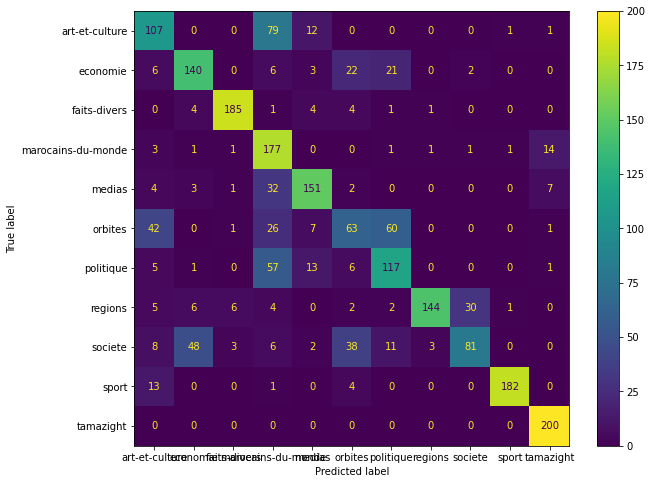

In [58]:
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_encoder.classes_)

fig, ax = plt.subplots(figsize=(10, 8))
cmd.plot(ax=ax)


Some insights from the metrics, the overall accuracy is 70%, and there are classes that scores low accuracy like `orbites` that is usually misclassified as `politique` or `art-et-culture`